In [378]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn.decomposition import PCA as sklearnPCA
#classifications
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import make_classification
import os
import pickle
from sklearn.model_selection import KFold
import sys
sys.path.insert(1, '../modules')
import data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.utils
from IPython.display import display, Audio
from sklearn.model_selection import RandomizedSearchCV
import umap
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import re
import tarfile
from sklearn.model_selection import KFold

import numpy_indexed as npi



ModuleNotFoundError: No module named 'numpy_indexed'

Gets summaries (mean, standard deviation, max, min) for each row in the embedding

In [2]:
def get_summary(embedding):
    embedding_mean = np.mean(embedding, axis=0)
    embedding_std = np.std(embedding, axis=0)
    embedding_max = np.amax(embedding, axis=0)
    embedding_min = np.amin(embedding, axis=0)
    embedding_summary = np.concatenate((embedding_mean, embedding_max, embedding_min, embedding_std))
    return embedding_summary

# Creating Y list of classifications

Divide annotations by day

In [3]:
with open('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/annotation_list.pickle', "rb") as f:
       annotation_list = pickle.load(f)

Converting timestamps in each element of the list to integers instead of floats

In [4]:
annotation_list = np.asarray([(int(timestamp), annotation) for (timestamp, annotation) in annotation_list])

In [5]:
annotation_list[0]

array(['1573060932', 'n'], dtype='<U21')

Sort annotation list by timestamp, then filter out anything that's not a yes or no

In [6]:
annotation_list_sorted = sorted(annotation_list, key=lambda tup: tup[0])

In [7]:
annotation_list_sorted[0]

array(['1573060932', 'n'], dtype='<U21')

In [8]:
annotation_list_sorted = \
np.asarray([annotation for annotation in annotation_list_sorted if (annotation[1] == 'y' or annotation[1] == 'n')])

In [9]:
len(annotation_list_sorted)

1524

In [10]:
annotation_list_sorted[:,0]

array(['1573060932', '1573061031', '1573061130', ..., '1573909778',
       '1573909961', '1573910184'], dtype='<U21')

# Manipulating Embeddings

In [11]:
embeddings = []

In [12]:
timestamps = []

Loading embeddings from folder

In [13]:
for folder in \
    os.listdir('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/embeddings'):
        for file in os.listdir\
        ('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/embeddings/' + folder):
            if(file.split('.')[0]) in annotation_list_sorted[:,0]:
                data = \
                np.load('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/embeddings/'\
                    + folder + '/' + file)
                emb = data['embedding']
                embeddings.append(emb)
                timestamps.append(file.split('.')[0])

In [14]:
X = np.asarray(embeddings)

In [15]:
X[0]

array([[0.95004624, 2.1188698 , 2.5096405 , ..., 2.2995567 , 2.0441778 ,
        1.8705485 ],
       [1.0311906 , 1.6677258 , 2.8326719 , ..., 2.0791793 , 2.3905044 ,
        1.7265162 ],
       [1.0773377 , 1.9739729 , 3.0342093 , ..., 2.0523002 , 2.4489102 ,
        1.7311425 ],
       ...,
       [1.3839877 , 2.754539  , 3.9604907 , ..., 1.7578768 , 1.8231161 ,
        2.8375812 ],
       [1.9356381 , 1.9932508 , 3.5124433 , ..., 2.2107465 , 1.5942514 ,
        2.3314993 ],
       [2.001265  , 2.0324519 , 3.3183138 , ..., 1.681724  , 1.8712686 ,
        2.184608  ]], dtype=float32)

Deleting timestamps that aren't in embeddings, so both arrays have the same size

In [16]:
annotation_list_cut = np.asarray([annotation for annotation in annotation_list if annotation[0] in timestamps])

In [17]:
annotation_list_cut.shape

(1509, 2)

In [18]:
annotation_list_cut[7]

array(['1573063463', 'n'], dtype='<U21')

1509 is the number of annotations excluding "maybes"

# Using Leave One Group Out method 

In [19]:
#y list is just the annotations
y = annotation_list_cut[:,1]

Replacing y and n with 1 and 0, used when calculating scores

In [20]:
y_binary = np.where(y=='n', 0, 1)

Computing class weights (we can see that they're not balanced)

In [21]:
test = np.array([0,1])

In [22]:
sklearn.utils.class_weight.compute_class_weight('balanced', test, y_binary)

/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.76135217, 1.45656371])

In [23]:
sample_weights = sklearn.utils.class_weight.compute_sample_weight('balanced', y_binary)

The groups used in cross-validation are the days

In [42]:
groups = np.asarray([data.convert_timestamps(int(timestamp)).day for timestamp in annotation_list_cut[:,0]])

In [43]:
logo = LeaveOneGroupOut()

# Separating positives from negatives

In [79]:
positive_mask = (y=='y')

In [95]:
positive_X = X[positive_mask]
positive_timestamps = annotation_list_cut[:,0][positive_mask]
positive_groups = groups[positive_mask]

In [96]:
positive_groups.shape

(518,)

In [97]:
negative_X = X[np.invert(positive_mask)]
negative_hard_timestamps = annotation_list_cut[:,0][np.invert(positive_mask)]
negative_groups = groups[np.invert(positive_mask)]

In [92]:
negative_X.shape

(991, 19, 512)

# random forest hyperparameter tuning

In [44]:
#make class to do pca with summaries
class pca_with_summaries(BaseEstimator, TransformerMixin):
    
    def __init__(self, pca):
        self.pca = pca
        
    def fit(self, X, y=None):
        expanded_X = np.reshape(X, (X.shape[0]*X.shape[1], 512))

        self.pca.fit(expanded_X)
        
        return self
  
    def transform(self, X, y=None):
        X_transformed = np.asarray([self.pca.transform(embedding) for embedding in X])

        X_summaries = np.asarray([get_summary(embedding) for embedding in X_transformed])
        
        return X_summaries

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Number of PCA (round 2) dimensions
n_components = [16, 32, 64, 128]
# Create the random grid
random_grid = {'more pca__n_components': n_components,
               'classifier__n_estimators': n_estimators,
               'classifier__max_depth': max_depth
              }
print(random_grid)

{'more pca__n_components': [16, 32, 64, 128], 'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [277]:
pipeline = Pipeline(steps=[
    ('pca with summaries', pca_with_summaries(sklearnPCA(45))),
    ('more pca', sklearnPCA()),
    ('standard scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
    ])
random_search = RandomizedSearchCV(pipeline, param_distributions=random_grid, \
                                   cv=LeaveOneGroupOut(), verbose = 3, n_iter=5)

In [108]:
random_search.fit(X, y_binary, groups=groups)
random_search.best_params_
#best params: 128 pca components, 1000 estimators, 100 max depth

(1509, 19, 512)
(1509,)
Fitting 9 folds for each of 10 candidates, totalling 90 fits
[CV] more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40, score=0.602, total=   7.7s
[CV] more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV]  more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40, score=0.613, total=   5.4s
[CV] more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s


[CV]  more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40, score=0.606, total=   5.4s
[CV] more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40 
[CV]  more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40, score=0.654, total=   5.5s
[CV] more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40 
[CV]  more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40, score=0.861, total=   5.7s
[CV] more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40 
[CV]  more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40, score=0.703, total=   5.3s
[CV] more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40 
[CV]  more pca__n_components=64, classifier__n_estimators=300, classifier__max_depth=40, score=0.653, total=   5.4s
[CV] more pca__n_components=64, classifier__n_estimators=300, classi

[CV]  more pca__n_components=16, classifier__n_estimators=200, classifier__max_depth=10, score=0.642, total=   3.2s
[CV] more pca__n_components=16, classifier__n_estimators=200, classifier__max_depth=10 
[CV]  more pca__n_components=16, classifier__n_estimators=200, classifier__max_depth=10, score=0.670, total=   3.2s
[CV] more pca__n_components=16, classifier__n_estimators=200, classifier__max_depth=10 
[CV]  more pca__n_components=16, classifier__n_estimators=200, classifier__max_depth=10, score=0.597, total=   3.2s
[CV] more pca__n_components=128, classifier__n_estimators=800, classifier__max_depth=20 
[CV]  more pca__n_components=128, classifier__n_estimators=800, classifier__max_depth=20, score=0.614, total=  13.8s
[CV] more pca__n_components=128, classifier__n_estimators=800, classifier__max_depth=20 
[CV]  more pca__n_components=128, classifier__n_estimators=800, classifier__max_depth=20, score=0.613, total=  12.7s
[CV] more pca__n_components=128, classifier__n_estimators=800, c

[CV]  more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10, score=0.593, total=   2.8s
[CV] more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10 
[CV]  more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10, score=0.606, total=   2.7s
[CV] more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10 
[CV]  more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10, score=0.645, total=   3.0s
[CV] more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10 
[CV]  more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10, score=0.835, total=   2.8s
[CV] more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10 
[CV]  more pca__n_components=16, classifier__n_estimators=100, classifier__max_depth=10, score=0.703, total=   2.7s
[CV] more pca__n_components=16, classifier__n_estimators=100, classi

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 10.2min finished


{'more pca__n_components': 128,
 'classifier__n_estimators': 1000,
 'classifier__max_depth': 100}

# logistic regression hyperparameter tuning

In [50]:
C = [x for x in np.linspace(start=1, stop=10, num=10)]
random_grid_logistic_regression = {
    'more pca__n_components': n_components,
    'classifier__C': C
}

In [53]:
pipeline = Pipeline(steps=[
    ('pca with summaries', pca_with_summaries(sklearnPCA(45))),
    ('more pca', sklearnPCA()),
    ('standard scaler', StandardScaler()),
    ('classifier', LogisticRegression())
    ])
random_search_logistic_regression = \
RandomizedSearchCV(pipeline, param_distributions=random_grid_logistic_regression, \
                   cv=LeaveOneGroupOut(), verbose = 1, n_iter=5)

In [146]:
random_search_logistic_regression.fit(X, y_binary, groups=groups)
random_search_logistic_regression.best_params_
#best params: PCA components=16, C=3.0/4.0??

Fitting 9 folds for each of 10 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.5min finished


{'more pca__n_components': 16, 'classifier__C': 4.0}

# KNN hyperparameter tuning

In [55]:
n_neighbors = [int(x) for x in np.linspace(start=5, stop=15, num=10)]
random_grid_knn = {
    'more pca__n_components': n_components,
    'classifier__n_neighbors': n_neighbors
}

In [56]:
pipeline = Pipeline(steps=[
    ('pca with summaries', pca_with_summaries(sklearnPCA(45))),
    ('more pca', sklearnPCA()),
    ('standard scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
    ])
random_search_knn = \
RandomizedSearchCV(pipeline, param_distributions=random_grid_knn, \
                   cv=LeaveOneGroupOut(), verbose = 1, n_iter=5)

In [149]:
random_search_knn.fit(X, y_binary, groups=groups)
random_search_knn.best_params_
#best params: PCA_components=32, n_neighbors=12/10?

Fitting 9 folds for each of 10 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.1min finished


{'more pca__n_components': 32, 'classifier__n_neighbors': 10}

# all 3 methods with best parameters

In [184]:
def predict_truck(x, y, groups, second_pca, classifier, cross_validation_method):
    for train_index, test_index in cross_validation_method.split(x, groups=groups):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        expanded_X_train = \
        np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 512))

        pca_45 = sklearnPCA(45)
        pca_45.fit(expanded_X_train)

        X_transformed = np.asarray([pca_45.transform(embedding) for embedding in X_train])

        X_summaries = np.asarray([get_summary(embedding) for embedding in X_transformed])

        #second round of PCA
        pca_128 = second_pca
        pca_128.fit(X_summaries)

        X_transformed_again = pca_128.transform(X_summaries)

        #standard scaler
        scaler = StandardScaler()
        scaler.fit(X_transformed_again)
        X_scaler = scaler.transform(X_transformed_again)

        #random forest on training data
        clf = classifier.fit(X_scaler, y_train)
    #     RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=1000).fit(X_scaler, y_train)

        #manipulate embeddings for each X_test
        expanded_X_test = \
        np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 512))

        X_test = np.asarray([pca_45.transform(embedding) for embedding in X_test])

        X_test_summaries = np.asarray([get_summary(embedding) for embedding in X_test])

        #second round of PCA on test data
        X_test_transformed_again = pca_128.transform(X_test_summaries)

        #standard scaler on test data
        X_test_scaler = scaler.transform(X_test_transformed_again)

        #get sample weights for y_test
        sample_weights = sklearn.utils.class_weight.compute_sample_weight('balanced', y_test)

        #get cross validation scores
        print('clf score: ', clf.score(X_test_scaler, y_test, sample_weight = sample_weights))

        #get f score, precision, recall
        #note: what average should I use???
        y_predicted = clf.predict(X_test_scaler)
        print('test labels: ', np.unique(y_test))
        print('predicted labels: ', np.unique(y_predicted))
        print\
        ('precision, recall, f score: ', precision_recall_fscore_support(y_test, y_predicted, average='macro'))

Random Forest

In [133]:
predict_truck(X, y, groups, sklearnPCA(128), \
              RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=1000), logo)

clf score:  0.5
predicted labels:  ['n']
precision, recall, f score:  (0.3068181818181818, 0.5, 0.38028169014084506, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.30402010050251255, 0.5, 0.378125, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.4999999999999999
predicted labels:  ['n']
precision, recall, f score:  (0.303125, 0.5, 0.377431906614786, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.4999999999999999
predicted labels:  ['n']
precision, recall, f score:  (0.32710280373831774, 0.5, 0.3954802259887006, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.4391304347826087, 0.5, 0.4675925925925926, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.3434065934065934, 0.5, 0.40716612377850164, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.3236842105263158, 0.5, 0.3929712460063898, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.34418604651162793, 0.5, 0.40771349862258954, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.49999999999999994
predicted labels:  ['n']
precision, recall, f score:  (0.30039525691699603, 0.5, 0.3753086419753086, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression

In [67]:
predict_truck(X, y, groups, sklearnPCA(16), LogisticRegression(class_weight='balanced', C=3.0), logo)

clf score:  0.576797385620915
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5824079485680889, 0.576797385620915, 0.5325819406658894, None)
clf score:  0.5283958465776648
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5312791783380019, 0.5283958465776648, 0.48450832994717596, None)
clf score:  0.4990181639666176
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.49906015037593987, 0.4990181639666176, 0.4903857496755928, None)
clf score:  0.51003861003861
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5098039215686274, 0.5100386100386101, 0.4671035386631718, None)
clf score:  0.4865629420084866
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.4942002442002442, 0.4865629420084866, 0.4262749445676275, None)
clf score:  0.5106666666666667
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.510567296996663, 0.5106666666666666, 0.5105989174087655, None)
clf score:  0.4764591675767506
predicted labels:  ['n' 'y']
precisi

KNN

In [68]:
predict_truck(X, y, groups, sklearnPCA(32), KNeighborsClassifier(n_neighbors=12), logo)

clf score:  0.5364923747276689
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5942334739803095, 0.5364923747276689, 0.49221891939150203, None)
clf score:  0.5178003814367451
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5812379110251451, 0.5178003814367451, 0.4428202610814152, None)
clf score:  0.5460644738995254
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6050765210899589, 0.5460644738995254, 0.5080959212953474, None)
clf score:  0.47702702702702693
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.43253968253968256, 0.47702702702702704, 0.4184782608695652, None)
clf score:  0.501060820367751
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5017523364485981, 0.5010608203677511, 0.4973776223776224, None)
clf score:  0.5015438596491228
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5104166666666666, 0.5015438596491228, 0.4337393872277593, None)
clf score:  0.521053270234195
predicted labels:  ['n' 'y']
pr

# checking data

Re-listening to embedding

In [78]:
def check_embedding(timestamp):
    date = str(data.convert_timestamps(timestamp)).split()[0]
    print('Ten-second audio clip corresponding to the image')
    display(Audio(filename=\
    '/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/10s/' + 
    date + '/' + str(timestamp) + '.wav'))

In [79]:
check_embedding(1573060932)

Ten-second audio clip corresponding to the image


finding out how well the model works on training data, so fitting everything only on training data

In [111]:
for train_index, test_index in logo.split(X, groups=groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    expanded_X_train = \
    np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 512))
  
    pca_45 = sklearnPCA(45)
    pca_45.fit(expanded_X_train)
   
    X_transformed = np.asarray([pca_45.transform(embedding) for embedding in X_train])

    X_summaries = np.asarray([get_summary(embedding) for embedding in X_transformed])
    #standard scaler
    scaler = StandardScaler()
    scaler.fit(X_summaries)
    X_scaler = scaler.transform(X_summaries)

    #random forest on training data
    clf = RandomForestClassifier().fit(X_scaler, y_train)

    y_predicted = clf.predict(X_scaler)

    print('precision, recall, f score: ', precision_recall_fscore_support(y_train, y_predicted, average='macro'))

precision, recall, f score:  (0.9947285688983352, 0.9927344170334371, 0.9937206969540299, None)
precision, recall, f score:  (0.9942739277391724, 0.9920323928944619, 0.9931402119726864, None)
precision, recall, f score:  (0.994441947861471, 0.9922880251739312, 0.9933528461053296, None)
precision, recall, f score:  (0.9941599169450621, 0.9931738303073808, 0.9936641359363703, None)
precision, recall, f score:  (0.9937845550205101, 0.9937845550205101, 0.9937845550205101, None)
precision, recall, f score:  (0.9955172032970895, 0.9945068707949883, 0.9950090266285543, None)
precision, recall, f score:  (0.9943224965621986, 0.9921960415666159, 0.9932468064408776, None)
precision, recall, f score:  (0.9965198623775751, 0.9949722903893549, 0.9957389665907321, None)
precision, recall, f score:  (0.9958104395604396, 0.9952109825846117, 0.9955098179831791, None)


In [141]:
for train_index, test_index in logo.split(X, groups=groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    expanded_X_train = \
    np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 512))
  
    pca_45 = sklearnPCA(45)
    pca_45.fit(expanded_X_train)
   
    X_transformed = np.asarray([pca_45.transform(embedding) for embedding in X_train])

    X_summaries = np.asarray([get_summary(embedding) for embedding in X_transformed])
    #standard scaler
    scaler = StandardScaler()
    scaler.fit(X_summaries)
    X_scaler = scaler.transform(X_summaries)

    #random forest on training data
    clf = LogisticRegression().fit(X_scaler, y_train)

    y_predicted = clf.predict(X_scaler)

    print('precision, recall, f score: ', precision_recall_fscore_support(y_train, y_predicted, average='macro'))

precision, recall, f score:  (0.6718635606270985, 0.6200893920283655, 0.6240315829155724, None)
precision, recall, f score:  (0.6947650417215635, 0.6448145245559038, 0.6528017913844686, None)
precision, recall, f score:  (0.6949940641076375, 0.6380964672910981, 0.6451038538196191, None)
precision, recall, f score:  (0.6898078159088235, 0.6419917787995963, 0.6488802203890199, None)
precision, recall, f score:  (0.6633549148918485, 0.6270643838059569, 0.6305563600564974, None)
precision, recall, f score:  (0.6540544444914239, 0.6095181676544112, 0.6113537491315268, None)
precision, recall, f score:  (0.6731997442380057, 0.6203993685307612, 0.6241689050165651, None)
precision, recall, f score:  (0.6876724320406984, 0.6375893296299511, 0.6433085149266118, None)
precision, recall, f score:  (0.6822783300198807, 0.6310312893904185, 0.637677096411144, None)


trying not splitting by day

In [ ]:
leaveOneOut = LeaveOneOut()

In [ ]:
for train_index, test_index in leaveOneOut.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train_timestamp, y_test_timestamp = annotation_list_cut[train_index], annotation_list_cut[test_index]
    
    y_train = y_train_timestamp[:,1]
    y_test = y_test_timestamp[:,1]
    
    expanded_X_train = \
    np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 512))
  
    pca_45 = sklearnPCA(45)
    pca_45.fit(expanded_X_train)
   
    X_transformed = np.asarray([pca_45.transform(embedding) for embedding in X_train])

    X_summaries = np.asarray([get_summary(embedding) for embedding in X_transformed])
    
    #standard scaler
    scaler = StandardScaler()
    scaler.fit(X_summaries)
    X_scaler = scaler.transform(X_summaries)

    #random forest on training data
    clf = RandomForestClassifier().fit(X_scaler, y_train)
    
    #manipulate embeddings for each X_test
    expanded_X_test = \
    np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 512))
    
    X_test = np.asarray([pca_45.transform(embedding) for embedding in X_test])

    X_test_summaries = np.asarray([get_summary(embedding) for embedding in X_test])
    
    #standard scaler on test data
    X_test_scaler = scaler.transform(X_test_summaries)
    
    #get cross validation scores
#     print('clf score: ', clf.score(X_test_scaler, y_test))
    
    #get f score, precision, recall
    #note: what average should I use???
    y_predicted = clf.predict(X_test_scaler)
    print(len(y_test_timestamp))
    print(len(y_predicted)
    print\
    ('precision, recall, f score: ', precision_recall_fscore_support(y_test, y_predicted, average='macro'))

# Cluster graphs

Raw openl3 features

In [28]:
X.shape

(1509, 19, 512)

In [29]:
expanded_X = np.reshape(X, (X.shape[0]*X.shape[1], 512))

In [30]:
expanded_X.shape

(28671, 512)

In [45]:
reducer = umap.UMAP()

In [32]:
embedding = reducer.fit_transform(expanded_X)
embedding.shape

(28671, 2)

In [33]:
expanded_y_binary = np.repeat(y_binary, 19)
expanded_y_binary.shape

(28671,)

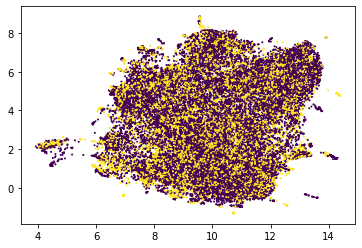

In [36]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=expanded_y_binary, s=1)

Summaries

In [37]:
X_summaries = np.asarray([get_summary(embedding) for embedding in X])

In [38]:
X_summaries.shape

(1509, 2048)

In [39]:
pca_128 = sklearnPCA(128)
X_reduced_summaries = pca_128.fit_transform(X_summaries, 128)

In [40]:
summary_embedding = reducer.fit_transform(X_reduced_summaries)

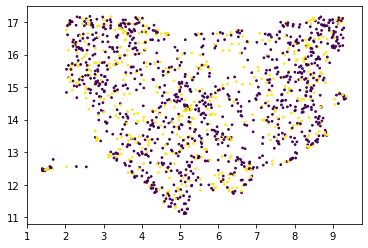

In [41]:
plt.scatter(summary_embedding[:, 0], summary_embedding[:, 1], c=y_binary, s=3)

In [43]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_reduced_summaries, y_binary)

In [46]:
reducer = umap.UMAP()
lda_reduced = reducer.fit_transform(X_lda)

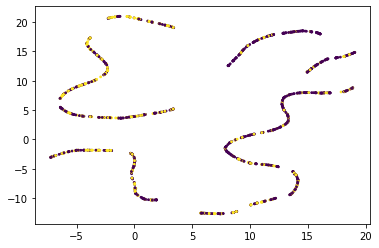

In [47]:
plt.scatter(lda_reduced[:, 0], lda_reduced[:, 1], c=y_binary, s=3)

In [197]:
X_summaries.shape

(1509, 2048)

In [198]:
y_binary.shape

(1509,)

# Including easy negatives

In [26]:
negative_embeddings = []
negative_timestamps = []

In [27]:
for folder in os.listdir('/green-projects/project-sonyc_redhook/workspace/share/negative_embeddings'):
    for file in os.listdir('/green-projects/project-sonyc_redhook/workspace/share/negative_embeddings/' + folder):
        data = np.load('/green-projects/project-sonyc_redhook/workspace/share/negative_embeddings/'+ \
                       folder + '/' + file)
        emb = data['embedding']
        if(emb.shape == (19, 512)):
            negative_embeddings.append(emb)
            negative_timestamps.append(file.split('.')[0])

In [28]:
len(negative_timestamps)

726

In [29]:
easy_negatives = np.asarray(negative_embeddings)

In [261]:
easy_negatives.shape

(726, 19, 512)

In [31]:
print(X.shape)
print(y.shape)

(1509, 19, 512)
(1509,)


In [32]:
len(timestamps)

1509

In [264]:
timestamps_with_easy_negatives = np.concatenate([timestamps, negative_timestamps])

In [34]:
#annotations for easy negatives, all of them are n
negatives = np.asarray(['n'] * len(easy_negatives))
#annotations including easy negatives
y_with_easy_negatives = np.concatenate([y, negatives])
#the same, but binary
y_with_easy_negatives_binary = np.where(y_with_easy_negatives=='n', 0, 1)

In [77]:
easy_negatives.shape

(726, 19, 512)

In [262]:
X_with_easy_negatives = np.concatenate([X, easy_negatives])

In [263]:
print(X_with_easy_negatives.shape)
print(y_with_easy_negatives.shape)

(2235, 19, 512)
(2235,)


In [98]:
easy_negative_groups = \
np.asarray([data.convert_timestamps(int(timestamp)).day for timestamp in negative_timestamps])

# Plotting distribution of easy/hard negatives, positives over each day

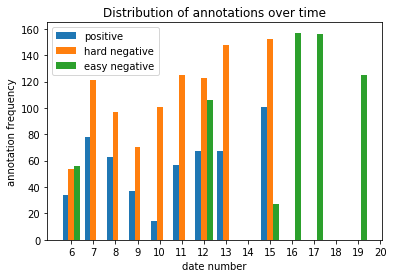

In [127]:
plt.hist([positive_groups, negative_groups, easy_negative_groups], \
         label=['positive', 'hard negative', 'easy negative'], \
         bins = np.arange(np.min(groups_with_easy_negatives), np.max(groups_with_easy_negatives)) - 0.5, \
         align = 'mid'
        )
plt.xticks(np.arange(np.min(groups_with_easy_negatives), np.max(groups_with_easy_negatives)))
plt.xlabel('date number')
plt.ylabel('annotation frequency')
plt.title("Distribution of annotations over time")
plt.legend(loc='upper left')

# Hyperparameter tuning with easy negatives

In [154]:
#Embeddings with only positive and easy negatives
X_easy = np.concatenate([positive_X, easy_negatives])
#The corresponding annotations for X_easy
y_easy = np.concatenate([np.asarray(['y'] * len(positive_X)), negatives])

Random forest hyperparameter tuning

In [163]:
#For now, using random CV splits because grouping by day doesn't make sense
pipeline = Pipeline(steps=[
    ('pca with summaries', pca_with_summaries(sklearnPCA(45))),
    ('more pca', sklearnPCA()),
    ('standard scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
    ])
random_search = RandomizedSearchCV(pipeline, param_distributions=random_grid, \
                                   cv=KFold(), verbose = 1, n_iter=5)

In [164]:
random_search.fit(X_easy, y_easy)
random_search.best_params_
#best params: 16 pca components, 700 estimators, 40 max depth

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.7min finished


{'more pca__n_components': 16,
 'classifier__n_estimators': 700,
 'classifier__max_depth': 40}

Logistic Regression hyperparameter tuning

In [172]:
pipeline = Pipeline(steps=[
    ('pca with summaries', pca_with_summaries(sklearnPCA(45))),
    ('more pca', sklearnPCA()),
    ('standard scaler', StandardScaler()),
    ('classifier', LogisticRegression())
    ])
random_search_logistic_regression = RandomizedSearchCV(pipeline, param_distributions=random_grid_logistic_regression, \
                                   cv=KFold(), verbose = 1, n_iter=5)

In [173]:
random_search_logistic_regression.fit(X_easy, y_easy)
random_search_logistic_regression.best_params_
#best params: PCA components=64, C=8.0

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   45.7s finished


{'more pca__n_components': 64, 'classifier__C': 8.0}

In [177]:
#For now, using random CV splits because grouping by day doesn't make sense
pipeline = Pipeline(steps=[
    ('pca with summaries', pca_with_summaries(sklearnPCA(45))),
    ('more pca', sklearnPCA()),
    ('standard scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
    ])
random_search_knn = RandomizedSearchCV(pipeline, param_distributions=random_grid_knn, \
                                   cv=KFold(), verbose = 1, n_iter=5)

In [178]:
random_search_knn.fit(X_easy, y_easy)
random_search_knn.best_params_
#best params: PCA_components=128, n_neighbors=10

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   47.7s finished


{'more pca__n_components': 128, 'classifier__n_neighbors': 10}

# Random forest, logistic regression, KNN with easy negatives

In [93]:
groups_with_easy_negatives = np.concatenate([groups, negative_groups])

Random Forest with easy negatives

In [188]:
predict_truck(X_easy, y_easy, None, sklearnPCA(16), \
              RandomForestClassifier(class_weight='balanced', max_depth=40, n_estimators=700), KFold(shuffle=True))

clf score:  0.6798492791612057
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7136130136986301, 0.6798492791612059, 0.6796146891083601, None)
clf score:  0.7056603773584905
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7123376623376624, 0.7056603773584906, 0.7084929757343551, None)
clf score:  0.7401896664486592
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7442146562042825, 0.7401896664486592, 0.7415863602668644, None)
clf score:  0.6971212325989998
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6971212325989999, 0.6971212325989999, 0.6971212325989999, None)
clf score:  0.6910633260998225
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7239306358381503, 0.6910633260998225, 0.6903225806451614, None)


Logistic Regression

In [189]:
predict_truck(X_easy, y_easy, None, sklearnPCA(64), \
              LogisticRegression(class_weight='balanced', C=8.0), KFold(shuffle=True))

clf score:  0.7282479926286692
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7237708091366628, 0.7282479926286691, 0.7217426512268199, None)
clf score:  0.7489826370048833
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7434350132625995, 0.7489826370048833, 0.7455651037740592, None)
clf score:  0.7848920863309351
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7813953488372093, 0.7848920863309352, 0.7818624269954575, None)
clf score:  0.7923868584245943
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.79043250327654, 0.7923868584245943, 0.7912893417700716, None)
clf score:  0.7406802721088435
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7330698287220027, 0.7406802721088436, 0.7350427350427351, None)


K Nearest Neighbors

In [190]:
predict_truck(X_easy, y_easy, \
              None, sklearnPCA(128), \
              KNeighborsClassifier(n_neighbors=10), KFold(shuffle=True))

clf score:  0.5051515151515151
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5524691358024691, 0.5051515151515151, 0.40261723009814615, None)
clf score:  0.5042891341933768
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5442386831275721, 0.5042891341933768, 0.3951321902785312, None)
clf score:  0.5163222324601818
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6463990554899646, 0.5163222324601816, 0.4084429824561404, None)
clf score:  0.5349999999999998
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.8078512396694215, 0.535, 0.4464947295456175, None)
clf score:  0.51016434558775
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6577868852459017, 0.51016434558775, 0.3868619884932646, None)


# Plotting attributes about data over time

In [330]:
X_timestamps = \
np.asarray\
([[embedding, timestamp] for embedding, timestamp in zip(X_with_easy_negatives, timestamps_with_easy_negatives)])


In [340]:
X_timestamps.shape

(2235, 2)

In [310]:
X_list = list(X_with_easy_negatives)

In [313]:
X_with_easy_negatives[0].shape

(19, 512)

In [315]:
X_list[0].shape

(19, 512)

In [328]:
len(np.where(X_with_easy_negatives == X_with_easy_negatives[0]))

3

In [334]:
X_timestamps[:,1][0]

'1573060932'

In [365]:
np.where((X_with_easy_negatives==X_with_easy_negatives[0]).all(-1))[-1]

/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


AttributeError: 'bool' object has no attribute 'all'

In [402]:
datetime_with_easy_negatives = \
[data.convert_timestamps(float(timestamp)) for timestamp in timestamps_with_easy_negatives]

In [403]:
datetime_with_easy_negatives[0]

datetime.datetime(2019, 11, 6, 12, 22, 12, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>)

In [469]:
def predict_truck_graph(x, y, groups, second_pca, classifier, cross_validation_method):
    for train_index, test_index in cross_validation_method.split(x, groups=groups):
        X_train, X_test =  x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        expanded_X_train = \
        np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 512))

        pca_45 = sklearnPCA(45)
        pca_45.fit(expanded_X_train)

        X_transformed = np.asarray([pca_45.transform(embedding) for embedding in X_train])

        X_summaries = np.asarray([get_summary(embedding) for embedding in X_transformed])

        #second round of PCA
        pca_128 = second_pca
        pca_128.fit(X_summaries)

        X_transformed_again = pca_128.transform(X_summaries)

        #standard scaler
        scaler = StandardScaler()
        scaler.fit(X_transformed_again)
        X_scaler = scaler.transform(X_transformed_again)

        #random forest on training data
        clf = classifier.fit(X_scaler, y_train)
    #     RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=1000).fit(X_scaler, y_train)

        #manipulate embeddings for each X_test
        expanded_X_test = \
        np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 512))

        X_test = np.asarray([pca_45.transform(embedding) for embedding in X_test])

        X_test_summaries = np.asarray([get_summary(embedding) for embedding in X_test])

        #second round of PCA on test data
        X_test_transformed_again = pca_128.transform(X_test_summaries)

        #standard scaler on test data
        X_test_scaler = scaler.transform(X_test_transformed_again)

        #get sample weights for y_test
        sample_weights = sklearn.utils.class_weight.compute_sample_weight('balanced', y_test)

        #get cross validation scores
        print('clf score: ', clf.score(X_test_scaler, y_test, sample_weight = sample_weights))

        #get f score, precision, recall
        #note: what average should I use???
        y_predicted = clf.predict(X_test_scaler)
        print('test labels: ', np.unique(y_test))
        print('predicted labels: ', np.unique(y_predicted))
        print\
        ('precision, recall, f score: ', precision_recall_fscore_support(y_test, y_predicted, average='macro'))
        
        #array of days 
        days_with_easy_negatives = np.asarray([datetime.day for datetime in datetime_with_easy_negatives])
        
        #get indices of false positives
        false_positive_index = test_index[(y_test != y_predicted) & (y_predicted=='y')]
        false_positive_days = days_with_easy_negatives[false_positive_index]
        
        #get indices of false negatives
        false_negative_index = test_index[(y_test != y_predicted) & (y_predicted=='n')]
        false_negative_days = days_with_easy_negatives[false_negative_index]
        
        #get indices of true positives
        true_positive_index = test_index[(y_test == y_predicted) & (y_predicted=='y')]
        true_positive_days = days_with_easy_negatives[true_positive_index]
        
        #get indices of true negatives
        true_negative_index = test_index[(y_test == y_predicted) & (y_predicted=='n')]
        true_negative_days = days_with_easy_negatives[true_negative_index]
        
        plt.hist([false_positive_days, false_negative_days, true_positive_days, true_negative_days], \
                label = ['false positive', 'false negative', 'true_positive', 'true_negative'], \
                stacked=True)
        plt.title('Distribution of labels over days')
        plt.xlabel('date number')
        plt.ylabel('frequency of labels')
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.show()

clf score:  0.5094541910331385
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.648469387755102, 0.5094541910331384, 0.3780553077609277, None)


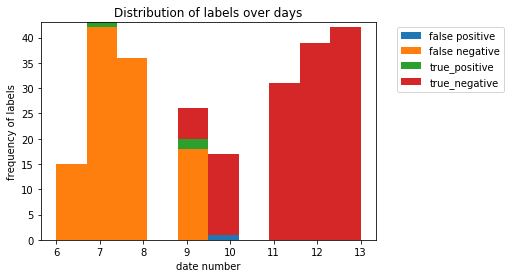

clf score:  0.5180722891566265
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.8373983739837398, 0.5180722891566265, 0.43779634228945585, None)


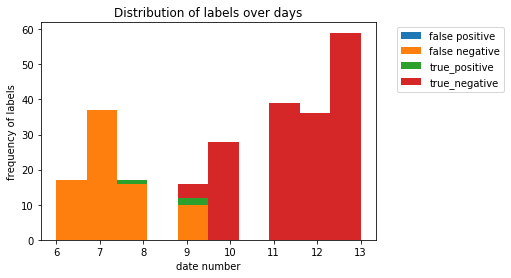

clf score:  0.5305559249900254
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.7383298755186722, 0.5305559249900252, 0.43774006564704243, None)


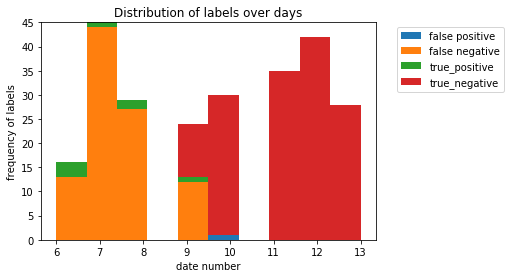

clf score:  0.5177070828331333
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6567296340023613, 0.5177070828331333, 0.41862220230654934, None)


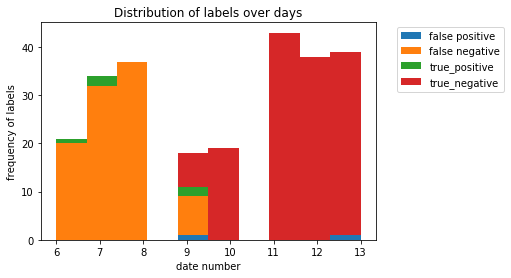

clf score:  0.5091431556948799
test labels:  ['n' 'y']
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6434426229508197, 0.5091431556948799, 0.373404255319149, None)


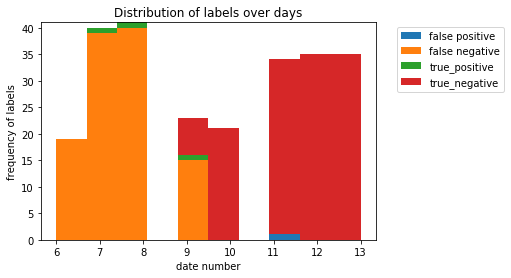

In [470]:
predict_truck_graph(X_easy, y_easy, \
              None, sklearnPCA(128), \
              KNeighborsClassifier(n_neighbors=10), KFold(shuffle=True))

# Hyperparameter tuning with easy and hard negatives

Random forest hyperparameter tuning

In [46]:
pipeline = Pipeline(steps=[
    ('pca with summaries', pca_with_summaries(sklearnPCA(45))),
    ('more pca', sklearnPCA()),
    ('standard scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
    ])
random_search = RandomizedSearchCV(pipeline, param_distributions=random_grid, \
                                   cv=LeaveOneGroupOut(), verbose = 3, n_iter=5)

In [58]:
random_search.fit(X_with_easy_negatives, y_with_easy_negatives_binary, groups=groups_with_easy_negatives)
random_search.best_params_
#best params: 128 pca components, 600 estimators, 10 max depth

Fitting 13 folds for each of 5 candidates, totalling 65 fits
[CV] more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100, score=0.757, total=  14.4s
[CV] more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


[CV]  more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100, score=0.663, total=  14.5s
[CV] more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.9s remaining:    0.0s


[CV]  more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100, score=0.731, total=  15.3s
[CV] more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100 
[CV]  more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100, score=0.673, total=  14.8s
[CV] more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100 
[CV]  more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100, score=0.539, total=  15.3s
[CV] more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100 
[CV]  more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100, score=0.665, total=  15.6s
[CV] more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100 
[CV]  more pca__n_components=64, classifier__n_estimators=400, classifier__max_depth=100, score=0.807, total=  13.0s
[CV] more pca__n_components=64, classifier__n_estimators=40

[CV]  more pca__n_components=128, classifier__n_estimators=600, classifier__max_depth=10, score=1.000, total=  16.2s
[CV] more pca__n_components=128, classifier__n_estimators=600, classifier__max_depth=10 
[CV]  more pca__n_components=128, classifier__n_estimators=600, classifier__max_depth=10, score=1.000, total=  18.2s
[CV] more pca__n_components=128, classifier__n_estimators=600, classifier__max_depth=10 
[CV]  more pca__n_components=128, classifier__n_estimators=600, classifier__max_depth=10, score=1.000, total=  17.6s
[CV] more pca__n_components=64, classifier__n_estimators=600, classifier__max_depth=40 
[CV]  more pca__n_components=64, classifier__n_estimators=600, classifier__max_depth=40, score=0.757, total=  18.4s
[CV] more pca__n_components=64, classifier__n_estimators=600, classifier__max_depth=40 
[CV]  more pca__n_components=64, classifier__n_estimators=600, classifier__max_depth=40, score=0.663, total=  15.9s
[CV] more pca__n_components=64, classifier__n_estimators=600, c

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 17.8min finished


{'more pca__n_components': 128,
 'classifier__n_estimators': 600,
 'classifier__max_depth': 10}

In [54]:
random_search_logistic_regression.fit\
(X_with_easy_negatives, y_with_easy_negatives_binary, groups=groups_with_easy_negatives)
random_search_logistic_regression.best_params_
#best params: PCA components=16, C=4.0

Fitting 13 folds for each of 5 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  7.4min finished


{'more pca__n_components': 16, 'classifier__C': 4.0}

In [57]:
random_search_knn.fit(X_with_easy_negatives, y_with_easy_negatives_binary, groups=groups_with_easy_negatives)
random_search_knn.best_params_
#best params: PCA_components=128, n_neighbors=13

Fitting 13 folds for each of 5 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  7.4min finished


{'more pca__n_components': 128, 'classifier__n_neighbors': 13}

# Random forest, logistic regression, KNN with easy and hard negatives (not relevant yet)

Random Forest with easy negatives

In [69]:
predict_truck(X_with_easy_negatives, y_with_easy_negatives, groups_with_easy_negatives, sklearnPCA(128), \
              RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=1000))

clf score:  0.4999999999999999
predicted labels:  ['n']
precision, recall, f score:  (0.3819444444444444, 0.5, 0.4330708661417323, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5
predicted labels:  ['n']
precision, recall, f score:  (0.3316582914572864, 0.5, 0.3987915407854985, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.365625, 0.5, 0.4223826714801444, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.3364485981308411, 0.5, 0.40223463687150834, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5
predicted labels:  ['n']
precision, recall, f score:  (0.26956521739130435, 0.5, 0.3502824858757062, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.49999999999999994
predicted labels:  ['n']
precision, recall, f score:  (0.3324175824175824, 0.5, 0.39933993399339934, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5
predicted labels:  ['n']
precision, recall, f score:  (0.40371621621621623, 0.5, 0.44672897196261685, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5000000000000001
predicted labels:  ['n']
precision, recall, f score:  (0.34418604651162793, 0.5, 0.40771349862258954, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.5
predicted labels:  ['n']
precision, recall, f score:  (0.3196428571428571, 0.5, 0.38997821350762524, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  1.0
predicted labels:  ['n']
precision, recall, f score:  (1.0, 1.0, 1.0, None)
clf score:  1.0
predicted labels:  ['n']
precision, recall, f score:  (1.0, 1.0, 1.0, None)
clf score:  1.0
predicted labels:  ['n']
precision, recall, f score:  (1.0, 1.0, 1.0, None)
clf score:  1.0
predicted labels:  ['n']
precision, recall, f score:  (1.0, 1.0, 1.0, None)


Logistic Regression

In [70]:
predict_truck(X_with_easy_negatives, y_with_easy_negatives, groups_with_easy_negatives, sklearnPCA(16), \
              LogisticRegression(class_weight='balanced', C=3.0))

clf score:  0.6505347593582887
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6091296762938554, 0.6505347593582887, 0.5675675675675677, None)
clf score:  0.48801447308909995
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.48886554621848743, 0.48801447308909995, 0.4549604382227632, None)
clf score:  0.4882727092029418
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.4904900064474533, 0.48827270920294175, 0.4782381842688812, None)
clf score:  0.5773809523809524
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5684210526315789, 0.5773809523809523, 0.560875512995896, None)
clf score:  0.5275410833840536
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5275410833840536, 0.5275410833840536, 0.5275410833840536, None)
clf score:  0.501083863975071
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5012437810945274, 0.5010838639750712, 0.4201183431952663, None)
clf score:  0.5598252954562138
predicted labels:  ['n' 'y']
pr

/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.9038461538461539
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5, 0.4519230769230769, 0.47474747474747475, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.76
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5, 0.38, 0.4318181818181818, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  0.6363636363636364
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5, 0.3181818181818182, 0.3888888888888889, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K Nearest Neighbors

In [71]:
predict_truck(X_with_easy_negatives, y_with_easy_negatives, groups_with_easy_negatives, sklearnPCA(32), \
              KNeighborsClassifier(n_neighbors=12))

clf score:  0.514705882352941
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.8846153846153846, 0.5147058823529411, 0.4633540372670808, None)
clf score:  0.5074626865671642
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.8333333333333333, 0.5074626865671642, 0.4147058823529412, None)
clf score:  0.49572649572649585
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.36477987421383645, 0.49572649572649574, 0.42028985507246375, None)
clf score:  0.5216269841269842
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.6746794871794872, 0.5216269841269842, 0.4560406698564593, None)
clf score:  0.5013694461351187
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5199115044247787, 0.5013694461351187, 0.3667532467532467, None)
clf score:  0.49986451700311607
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.4990530303030303, 0.4998645170031161, 0.4237901402080506, None)
clf score:  0.5045878294061513
predicted labels:  ['n' 'y']


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  1.0
predicted labels:  ['n']
precision, recall, f score:  (1.0, 1.0, 1.0, None)
clf score:  0.992
predicted labels:  ['n' 'y']
precision, recall, f score:  (0.5, 0.496, 0.4979919678714859, None)


/home/cusp/meh708/.conda/envs/truck_update/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clf score:  1.0
predicted labels:  ['n']
precision, recall, f score:  (1.0, 1.0, 1.0, None)
